In [130]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import operator
import matplotlib.pyplot as plt

MAX_Q_LEN = 25
MAX_A_LEN = 7

In [131]:
# Helper functions to read data

from pathlib import Path
import re
import numpy as np

def ps(s):
    """Process String: convert a string into a list of lowercased words."""
    return [word.strip() for word in re.split(r'([+-/*()?]|\d|\w)', s) if word.strip()]

def read_data(filepath):
    '''
    returns character lists of questions and answers.
    '''
    # q,a lists
    X = []
    y = []

    with open(filepath) as dataset_file:
        # Grabbing a subset of the entire file
        for i in range(1000000):
            line_q = dataset_file.readline().strip()
            line_a = dataset_file.readline().strip()
            if(len(line_q) < MAX_Q_LEN and len(line_a) < MAX_A_LEN):
                X.append(ps(line_q))
                y.append(ps(line_a))   
    return X,y

def pad_data(X,y, max_question_len, max_answer_len):
    # dataset is of form [(q,a)]
    X_padded = list()
    for q in X:
        qpad =  ['BOE'] + q + ['EOE'] + ['#' for _ in range(max_question_len-len(q))] 
        X_padded.append(qpad)
    y_padded = list()
    for a in y:
        apad =  ['BOE']  + a + ['EOE'] + ['#' for _ in range(max_answer_len-len(a))]
        y_padded.append(apad)
    return X_padded,y_padded

In [132]:
def create_alphabet_index(X):

    char_to_int = {}
    char_to_int['#'] = 0
    for q in X:
        for word in q:
            if word not in char_to_int:
                char_to_int[word] = len(char_to_int)
    
    int_to_char = dict([(char_to_int[char],char) for char in char_to_int])

    return (char_to_int,int_to_char)

def encode_data(X,y,char_to_int):
    Xenc = list()
    
    for pattern in X:
        integer_encoded = [char_to_int[char] for char in pattern]
        Xenc.append(integer_encoded)
    yenc = list()
    for pattern in y:
        integer_encoded = [char_to_int[char] for char in pattern]
        yenc.append(integer_encoded)
    
    return Xenc, yenc

# one hot encode
def one_hot_encode(X, y, vocab_size):
	Xenc = list()
	for seq in X:
		pattern = list()
		for index in seq:
			vector = [0 for _ in range(vocab_size)]
			vector[index] = 1
			pattern.append(vector)
		Xenc.append(pattern)
	yenc = list()
	for seq in y:
		pattern = list()
		for index in seq:
			vector = [0 for _ in range(vocab_size)]
			vector[index] = 1
			pattern.append(vector)
		yenc.append(pattern)
	return Xenc, yenc

def one_hot_decode(seq, int_to_char):
	strings = list()
	for pattern in seq:
		string = int_to_char[np.argmax(pattern)]
		strings.append(string)
	return ''.join(strings)

def process_data(dataset_filename):
    X,y = read_data(dataset_filename)
    X,y = pad_data(X,y,MAX_Q_LEN,MAX_A_LEN)
    X_train,X_test,y_train, y_test = train_test_split(X,y, test_size = 0.2)
    char_to_int,int_to_char = create_alphabet_index(X_train)
    X_train,y_train = encode_data(X_train,y_train,char_to_int)
    X_test,y_test = encode_data(X_test,y_test,char_to_int)
    # X,y = one_hot_encode(X,y,len(char_to_int))
    return (X_train, y_train, X_test,y_test,char_to_int,int_to_char)

In [133]:
# Alternative method to generate dataset, in case our original dataset doesn't work.

valid_characters = '0123456789.+*-/ '
char_to_int = dict((character, index) for index, character in  enumerate(valid_characters))
int_to_char = dict((index, character) for index, character in  enumerate(valid_characters))

number_max = 100 #Up to this number
MAX_Q_LEN = len(str(number_max-1)) * 2 + 1
MAX_A_LEN = MAX_Q_LEN
operators = ['+', '*', '-', '/']
operators_dict = { "+":operator.add, 
                  '*':operator.mul, 
                  "-":operator.sub,
                  '/':operator.truediv}

def oper_generator():
    number_1 = np.random.randint(1,number_max)
    operator_index = np.random.randint(0,len(operators))
    operator = operators[operator_index]
    number_2 = np.random.randint(1,number_max)
    number_1= max(number_1,number_2)
    number_2= min(number_1,number_2)
    operation = str(number_1) + operator + str(number_2)
    result = str(operators_dict[operator](number_1,number_2))[:MAX_A_LEN]
    return ps(operation), ps(result)

def data_generator(training_size,test_size):
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    for i in (range(0, training_size)):
        x, y = oper_generator()
        x_train.append(x)
        y_train.append(y)
    for i in (range(0, test_size)):
        x, y = oper_generator()
        x_test.append(x)
        y_test.append(y)
    X,y = pad_data(x_train,y_train,MAX_Q_LEN,MAX_A_LEN)
    X,y = encode_data(X,y,char_to_int)
    X,y = one_hot_encode(X,y,len(char_to_int))
    X_test,y_test = pad_data(x_test,y_test,MAX_Q_LEN,MAX_A_LEN)
    X_test,y_test = encode_data(X_test,y_test,char_to_int)
    X_test,y_test = one_hot_encode(X_test,y_test,len(char_to_int))
    return X,y,X_test,y_test

data_points = 10000
test_size = 0.2
training_size = int(round(data_points * (1-test_size),0))
test_size = data_points - training_size

In [9]:
def mean_absolute_error(y_true, y_pred):

    #for comparing, let's take exact values
    y_true_max = K.argmax(y_true)
    y_pred_max = K.argmax(y_pred)
    print(y_true_max, y_pred_max)
    
    
    #compare with a proper tensor function
    equal_mask = K.equal(y_true_max,y_pred_max)
    is_start = K.equal(y_true_max, 1)
    is_end = K.equal(y_true_max, 8)

    #cast to float for multiplying and summing
    equal_mask = K.cast(equal_mask, K.floatx()) 
    is_start = K.cast(is_start, K.floatx())
    is_end = K.cast(is_end, K.floatx())
        #these are tensors with 0 (false) and 1 (true) as float
    
    #entire condition as you wanted
    condition = (is_start + is_end) * equal_mask
        # sum = or ||| multiply = and
        # we don't have to worry about the sum resulting in 2
            # because you will never have startToken == endToken

    #reverse condition:
    condition = 1 - condition
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    #result
    return condition * K.mean(K.abs(y_pred - y_true), axis=-1)

In [ ]:
n_batch = 128
n_epoch = 1

dataset_filename = Path("../train_data/arithmetic__mixed.txt")
X_train,y_train,X_test,y_test, char_to_int,int_to_char = process_data(dataset_filename)

# X,y, _, _ = data_generator(training_size,test_size)
model = Sequential()
model.add(Embedding(len(char_to_int), 30, input_length=MAX_Q_LEN+2, mask_zero = True))
model.add(LSTM(128, input_shape=(MAX_Q_LEN+2, len(char_to_int))))
model.add(RepeatVector(MAX_A_LEN+2))
model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(len(char_to_int), activation='softmax'))),

checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
print(model.summary())

#class_weight = {i:1. for i in range(len(char_to_int))}
#class_weight[char_to_int[' ']] = ratio
_, y_train = one_hot_encode([],y_train, len(char_to_int))
_, y_test = one_hot_encode([],y_test,len(char_to_int))
# train LSTM
history = model.fit(np.array(X_train), np.array(y_train), validation_data=(X_test, y_test),
                    epochs=n_epoch, batch_size=n_batch)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 7, 30)             90        
                                                                 
 lstm_26 (LSTM)              (None, 128)               81408     
                                                                 
 repeat_vector_13 (RepeatVec  (None, 7, 128)           0         
 tor)                                                            
                                                                 
 lstm_27 (LSTM)              (None, 7, 128)            131584    
                                                                 
 time_distributed_13 (TimeDi  (None, 7, 3)             387       
 stributed)                                                      
                                                                 
Total params: 213,469
Trainable params: 213,469
Non-t

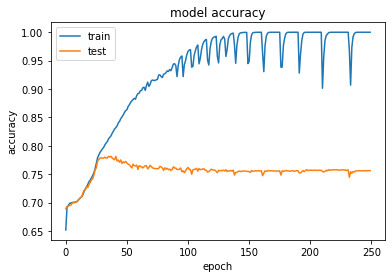

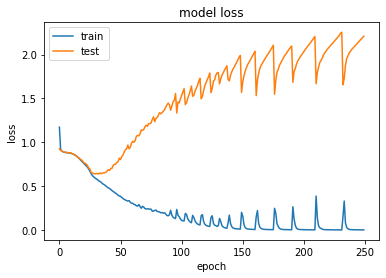

<Figure size 432x288 with 0 Axes>

In [120]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("numsam=1000k_q25_a7")

In [129]:
# evaluate on some new patterns
result = model.predict(X_test, verbose=0)
# calculate error
expected = [one_hot_decode(x, int_to_char) for x in y_test]
predicted = [one_hot_decode(x, int_to_char) for x in result]
# show some examples
for i in range(100):
	print('Expected=%s, Predicted=%s' % (expected[i], predicted[i]))

Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=BOEEOE#####
Expected=BOEEOE#####, Predicted=